Решение задачи предсказания поломки прибора по временым рядам. В данном решении продемонстрировано два подхода, первый - на основе предсказания поломки прибора в некотором временном окне $[t; t + window\_size]$ (решение задачи классификации), с последующим предсканием точного времени в данном окне (решение задачи регрессии) с целью получения более точного прогноза поломки. Также для решения данной задачи были опробованы реккурентные нейросетети для 
анализа выживаемости на основе моделирования <a href="https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%92%D0%B5%D0%B9%D0%B1%D1%83%D0%BB%D0%BB%D0%B0">распределения Вейбулла</a>.

In [458]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import random
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, \
                            RandomForestClassifier, GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score, mean_squared_error as mse

from sklearn.preprocessing import StandardScaler, MinMaxScaler

Проведём начальный анализ имеющихся данных

In [318]:
FILENAME = 'data.csv'
TRAIN_SIZE = 0.6
dataFrame = pd.read_csv(FILENAME)
print("Dataset size: ", dataFrame.shape)
dataFrame.head(10)

Dataset size:  (16138, 25)


,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
5,1,6,518.67,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,...,23.3669,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,-0.0043,-0.0001
6,1,7,518.67,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,...,23.3774,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,0.0010,0.0001
7,1,8,518.67,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,...,23.3106,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,-0.0034,0.0003
8,1,9,518.67,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,...,23.4066,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,0.0008,0.0001
9,1,10,518.67,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,...,23.4694,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,-0.0033,0.0001


Построим графики временных рядов и оконное скользящее среднее для первого прибора 

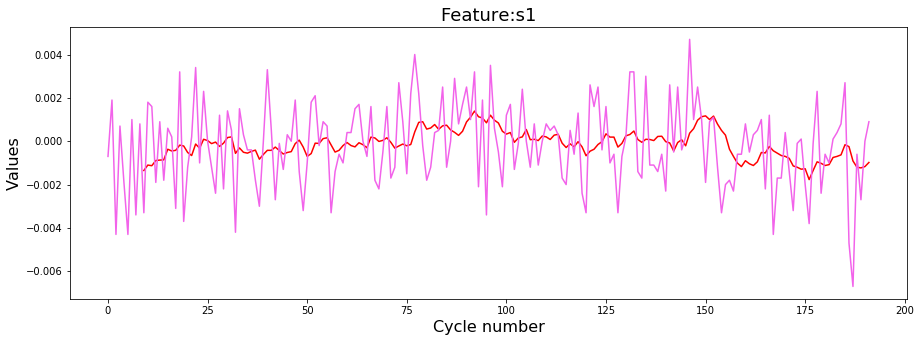

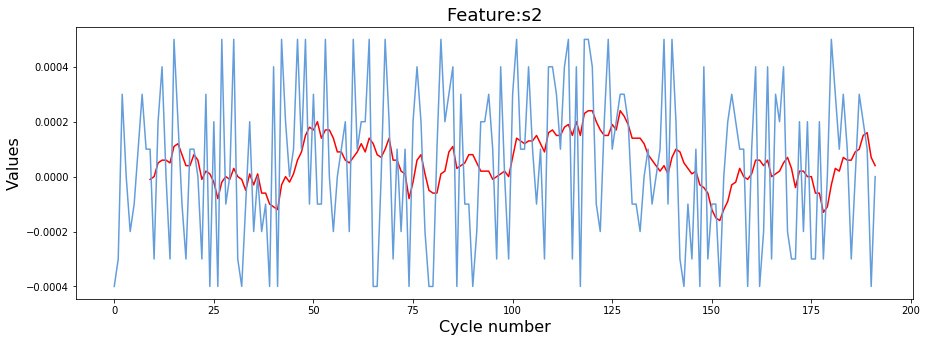

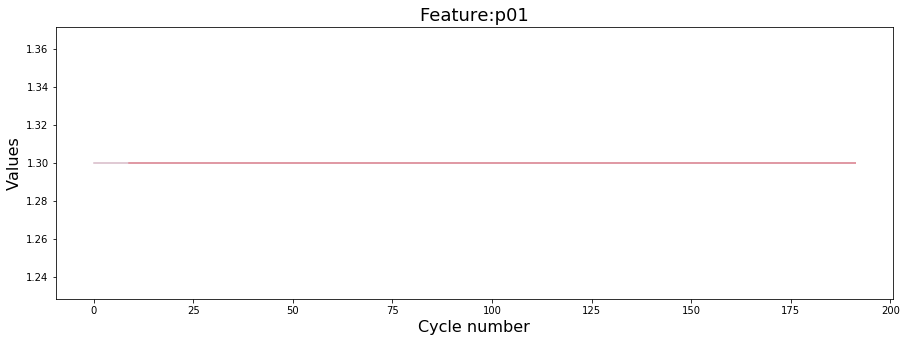

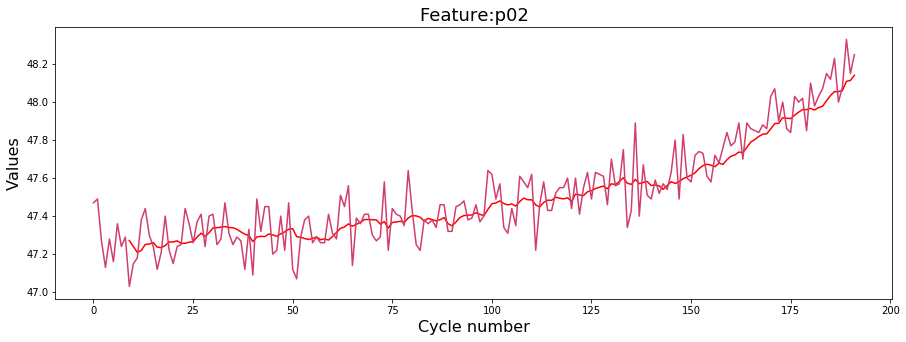

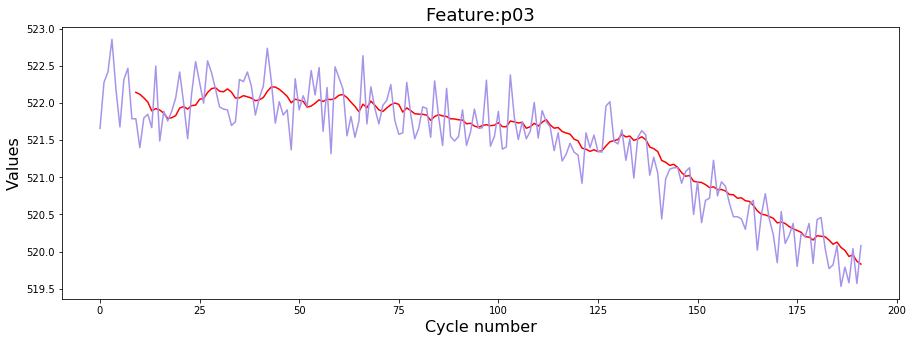

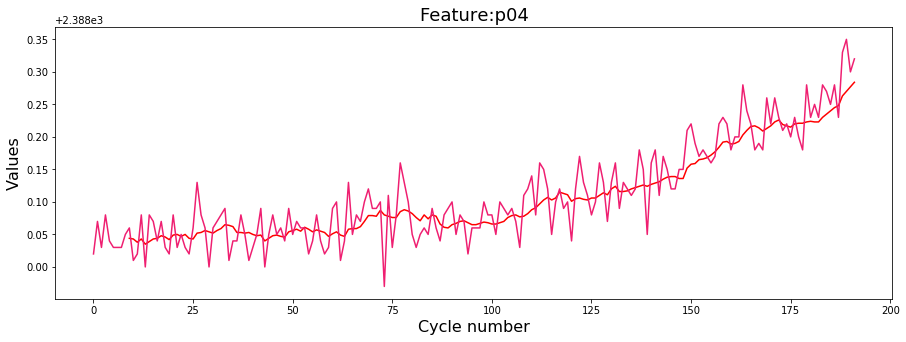

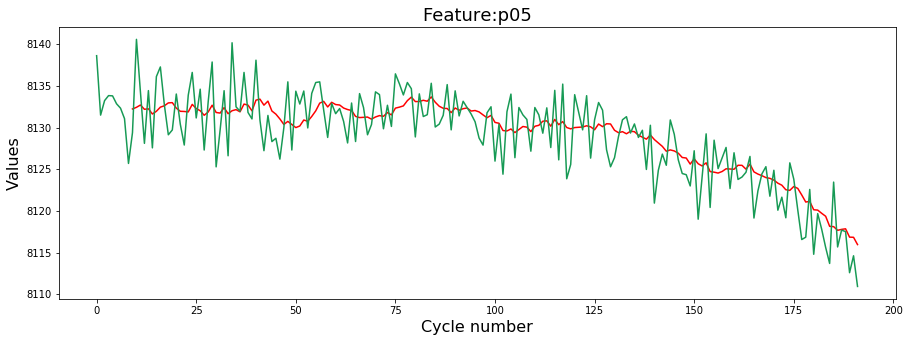

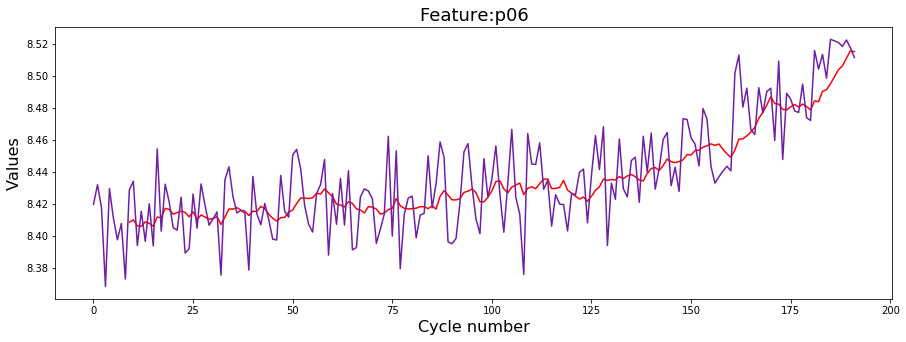

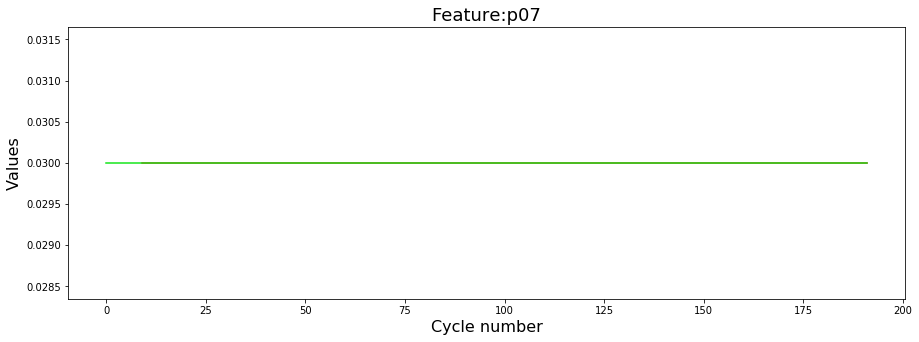

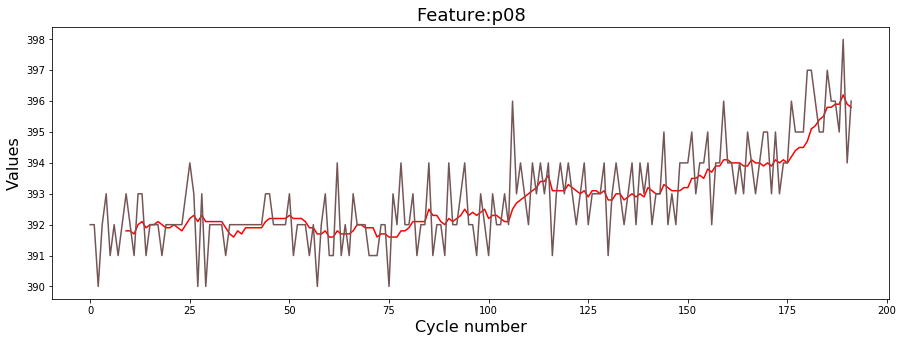

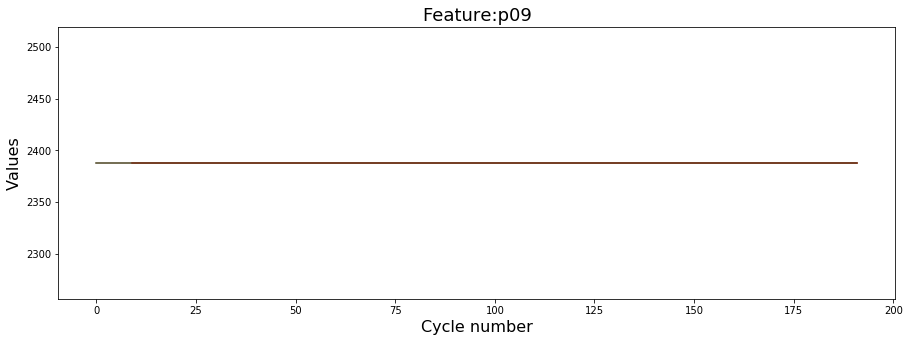

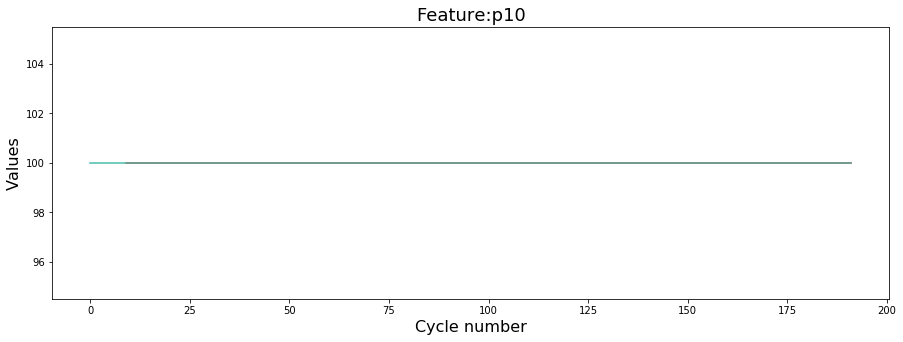

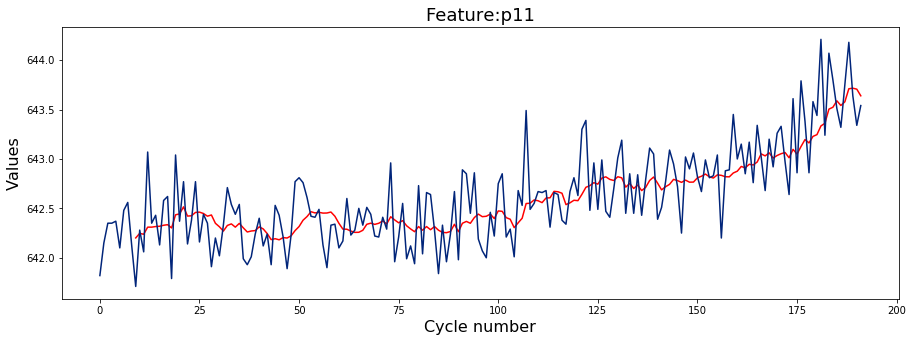

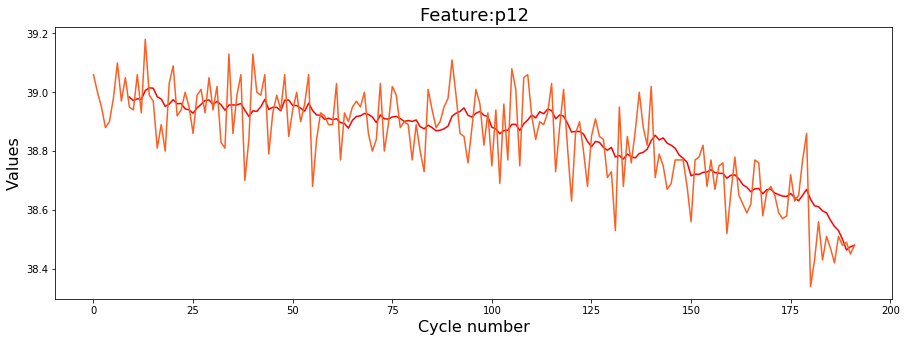

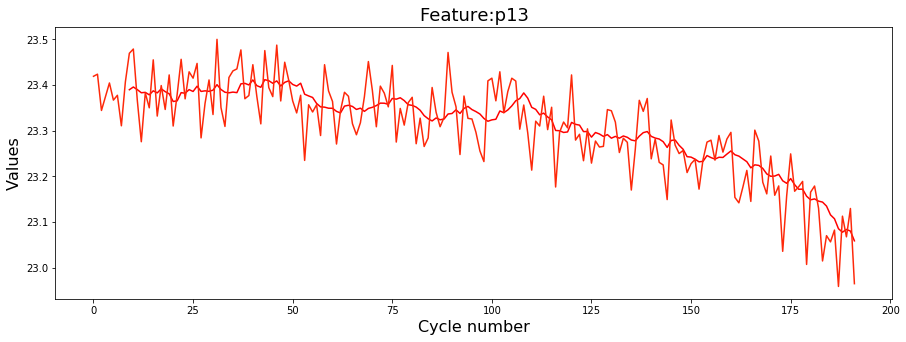

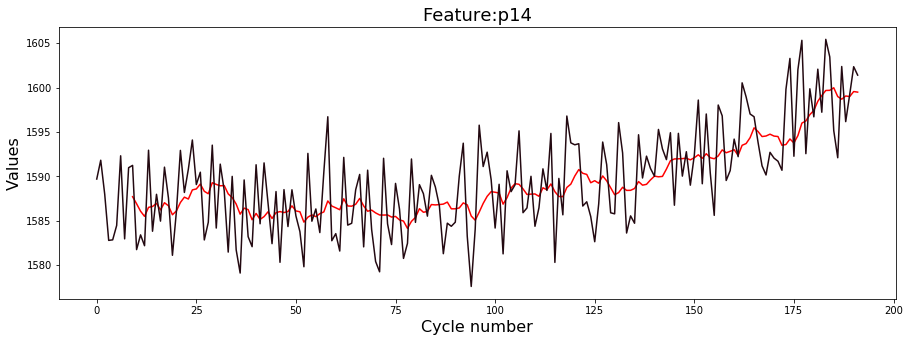

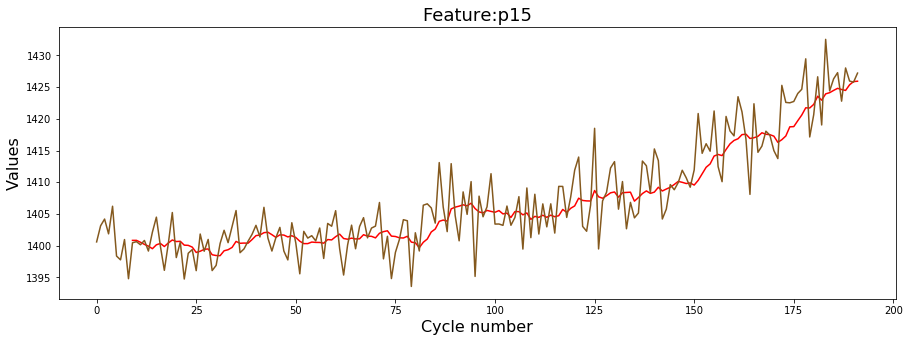

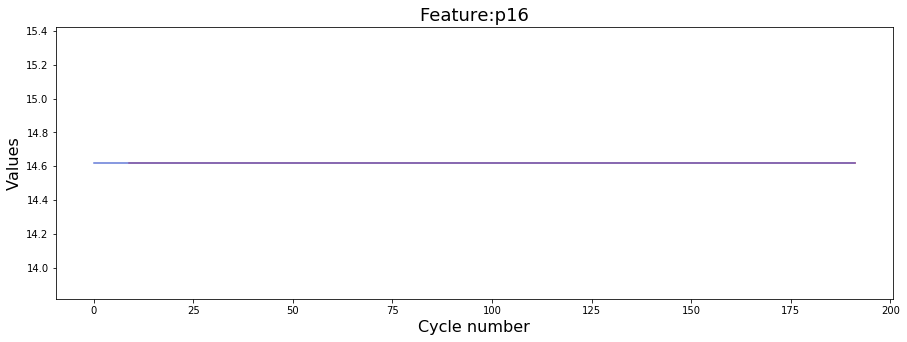

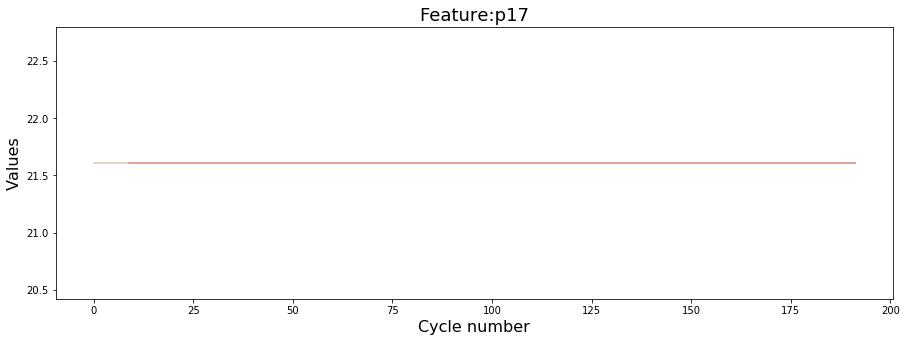

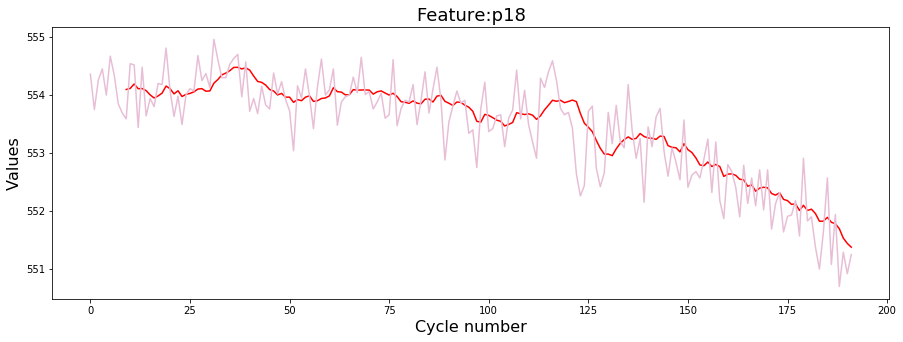

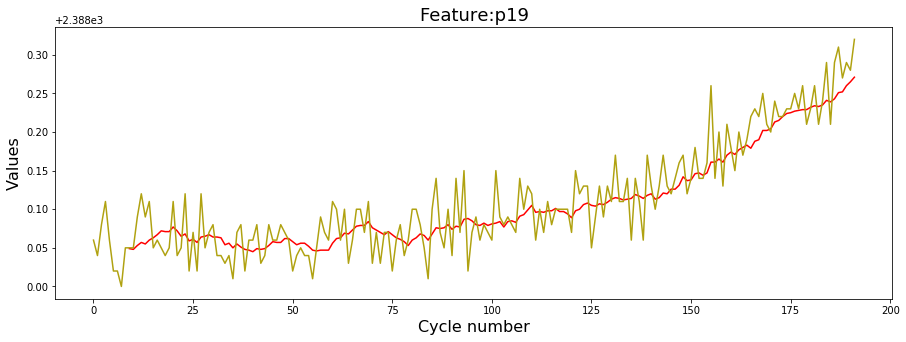

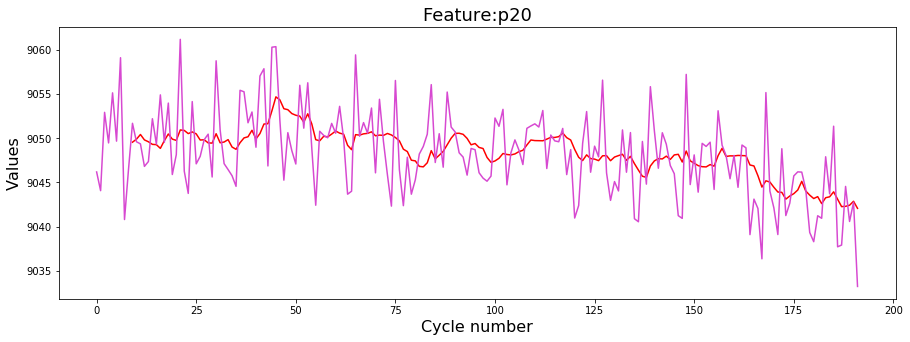

In [319]:
def visualize_feature(data, feature_name, step=1):
    
    features = data[feature_name]
    plt.figure(figsize=(15,5))

    trend = features.rolling(window=10).mean()
    features = features[::step]
    trend = trend[::step]
    
    plt.plot(range(len(trend)), trend, color = 'r')
    plt.plot(range(len(features)),features, color = np.random.rand(3,))
    plt.xlabel("Cycle number", fontsize=16)
    plt.ylabel("Values", fontsize=16)
    plt.title("Feature:{}".format(feature_name), fontsize=18)
    plt.show()
    

sensors = ['s1', 's2'] + ['p' + '{}'.format(i).zfill(2) for i in range(1,21)]
data = dataFrame[dataFrame['id'] == 1]

for sensor in sensors:
    visualize_feature(data, sensor)

Очевидный вывод из проделанной визуализации - показания не всех датчиков несут полезную информацию, поэтому перед обучением моделей проведём фильтрацию признаков.

In [320]:
#вспомогательные функции для обработки

def get_id_data(data, id_vehicle):
        id_data = data[data['id']==id_vehicle]
        return id_data
        
def find_constant_values(data, eps=1e-6):
    def check_constant(values):
        return len(set(values)) == 1
    
    not_const = []
    for column_name in data:
        if not check_constant(data[column_name]):
            not_const.append(column_name)
    return not_const

In [321]:
#фильтрация признаков
columns = []
for id in dataFrame.id.unique():
    id_data = get_id_data(dataFrame, id)
    #print(id_data.head(5))
    not_const = find_constant_values(id_data)
    #print(not_const)
    columns.extend([column_name for column_name in not_const 
                              if column_name not in columns])
id_col = 'id'
cycle_col = 'cycle'
feature_cols = columns[1:-1]
print(feature_cols)

dataFrame = dataFrame[[id_col, cycle_col] + feature_cols]
dataFrame[id_col] -= 1
dataFrame[cycle_col] -= 1
dataFrame.head(2)

['p02', 'p03', 'p04', 'p05', 'p06', 'p08', 'p11', 'p12', 'p13', 'p14', 'p15', 'p18', 'p19', 'p20', 's1', 's2']


,id,cycle,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p18,p19,p20,s1,s2
0,0,0,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,554.36,2388.06,9046.19,-0.0007,-0.0004
1,0,1,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,553.75,2388.04,9044.07,0.0019,-0.0003


Поделим всю имеющуюся выборку на данные для обучения и тестирования в пропорции 4:1

In [303]:
def createTrainTest(dataFrame, train_size, shuffle = True):
    ids = list(dataFrame.id.unique())
    if shuffle:
        random.shuffle(ids)
    
    train_ids = ids[:int(train_size * len(ids))]
    test_ids = ids[int(train_size * len(ids)):]
    
    train_set = dataFrame[dataFrame.id.isin(train_ids)]
    test_set = dataFrame[dataFrame.id.isin(test_ids)]
    
    return train_set, test_set

train_set, test_set = createTrainTest(dataFrame, 0.8)

print("Size of train data: {}, test data: {}".format(len(train_set), len(test_set)))

Size of train data: 13069, test data: 3069


Т.к. в присутвующих данных нет никаких меток, то на основе времени поломки сгенрируем два типа меток:
- Первый тип - для решения задачи классификации, цикл имеет метку 1, если до поломки прибора осталось меньше, чем N циклов работы, иначе - 0
- Второй тип - для решения задачи регресии, в качестве целевого значение - количество оставшихся циклов работы 

In [328]:
def create_regression_labels(data):
    data.loc[:, 'lifetime'] = np.nan
    for id in data.id.unique():
        
        id_data = get_id_data(data,id)
        max_cycle = id_data['cycle'].max()
        data.loc[data['id']==id, 'lifetime'] = max_cycle - id_data.cycle + 1
        
    return data

def create_classification_labels(data, future_window=30):
    data.loc[:, 'broke'] = 0
    
    for id in data.id.unique():
        id_data = get_id_data(data, id)
        max_cycle = id_data['cycle'].max()
        data.loc[(data['id'] == id) & (max_cycle - data['cycle'] <= future_window), 'broke'] = 1 

    return data
        

        
train_set = create_regression_labels(train_set)
train_set = create_classification_labels(train_set, 20)
test_set = create_regression_labels(test_set)
test_set = create_classification_labels(test_set, 20)


In [329]:
train_set.head(2)

,id,cycle,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p18,p19,p20,s1,s2,lifetime,broke
0,0,0,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,554.36,2388.06,9046.19,-0.0007,-0.0004,192.0,0
1,0,1,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,553.75,2388.04,9044.07,0.0019,-0.0003,191.0,0


В качестстве признаков на основе, которых будут обучаться различные модели, - аггрегированные статистики в некотором временном окне $[t, t - s]$, где s - размер окна + разница в значении признаков в текущей временной точке и некотором прошлом цикле (лаг). 
В качесcтве оконных статистик использовались функции:
- медиана
- максимум
- минимум
- среднее
- стандартное отклонение

In [330]:
def speed(values):
    return values.max() - values.min()


In [395]:
# функци для генерации признаков для некоторой временной точки

def create_features(data, features_names, point, window_size, lags = [20, 40, 60]):
    functions_list = [np.median, np.max, np.min, np.mean, np.std, speed]
    
    def compute_feature_statistics(start, end, feature_name):
            
        df = data[(data['cycle']>= start) & (data['cycle']<=end)][feature_name]
        new_features = []
        for function in functions_list:
            new_features.append(function(df))
        return new_features
    
    def compute_lag(rolling_mean, point, lag_size):
        
        if point > lag_size + window_size:
            point_feature = rolling_mean[point]
            p_point_feature = rolling_mean[point - lag_size]
        
            return point_feature - p_point_feature
        else:
            return 0
        
         
    features = []
    for feature_name in features_names:
        rolling_mean = np.asarray(data[feature_name].rolling(window=window_size).mean())
        #print(rolling_mean)
        new_features = compute_feature_statistics(max(0, point - window_size), point, feature_name)
        for lag_size in lags:
            lag = compute_lag(rolling_mean, point,  lag_size)
            #print(lag)
            new_features.append(lag)
        
        features.extend(new_features)
        
    lifetime = data[data['cycle'] == point]['lifetime']
    broke = data[data['cycle'] == point]['broke']
    
    return features, lifetime.values, broke.values

In [605]:
def create_train_dataset(data, size, window_size, columns):
    X = []
    y_reg = []
    y_class = []
    ids = data.id.unique()
    
    for i in range(size):
        random_id = np.random.choice(ids, 1, replace=True)[0]
        machineData = data[data['id'] == random_id]
        cycle_length = len(machineData)
        random_cycle = np.random.randint(window_size + 1, cycle_length)
        
        features, lifetime, broke = create_features(machineData,
                                             columns,
                                             random_cycle,
                                             window_size)
        
        X.append(features)
        y_reg.append(*lifetime)
        y_class.append(*broke)
        
    
    X = np.asarray(X)
    y_reg = np.asarray(y_reg)
    y_class = np.asarray(y_class)
    return X, y_reg, y_class



train_X, train_y_reg, train_y_class = create_train_dataset(train_set, 
                                                          2000, 
                                                          5, 
                                                          feature_cols)

In [606]:
#функция для балансировки классов
def resample(train_X, train_y_class, train_y_reg):
    n_first = np.count_nonzero(train_y_class == 0)
    n_second = np.count_nonzero(train_y_class == 1)
    n_min = min(n_second, n_first)
    
    positions_first = train_X[train_y_class==0][:n_min]
    positions_second = train_X[train_y_class == 1][:n_min]
    
    train_y_reg_first = train_y_reg[train_y_class==0][:n_min]
    train_y_reg_second = train_y_reg[train_y_class==1][:n_min]
    #print(positions_first.shape, positions_second.shape)
    
    
    concatenated_X = np.concatenate((positions_first, positions_second), axis=0)
    concatenated_y_reg = np.concatenate((train_y_reg_first, train_y_reg_second))
    train_y_class = np.asarray([0 for i in range(n_min)] + [1 for i in range(n_min)])
    
    return concatenated_X, train_y_class, concatenated_y_reg

<IPython.core.display.Javascript object>


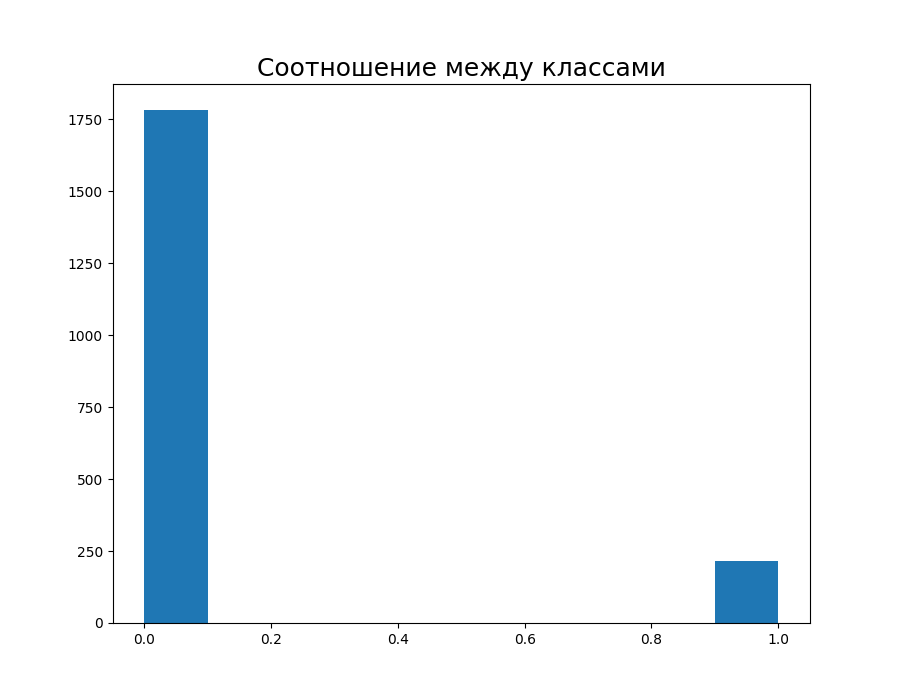

<IPython.core.display.Javascript object>


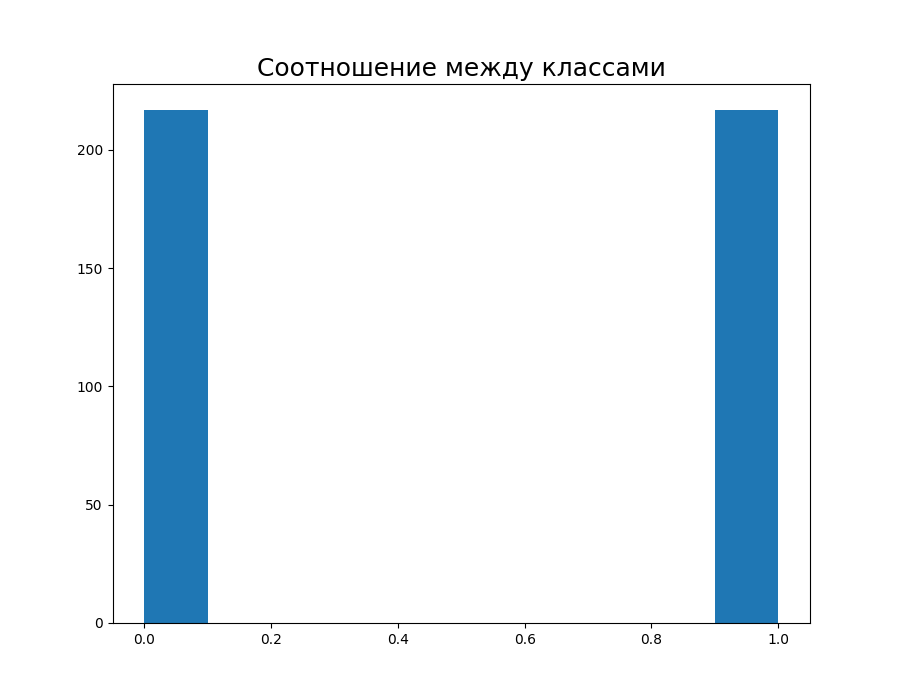

In [607]:
number_first_class = np.count_nonzero(train_y_class == 0)
number_second_class = np.count_nonzero(train_y_class == 1)


plt.figure(figsize = (9,7))
plt.hist(train_y_class)
plt.title("Соотношение между классами", fontsize=18)
plt.show()

#т.к. сбалансируем классы
train_X, train_y_class, train_y_reg = resample(train_X, train_y_class, train_y_reg)

number_first_class = np.count_nonzero(train_y_class == 0)
number_second_class = np.count_nonzero(train_y_class == 1)


plt.figure(figsize = (9,7))
plt.hist(train_y_class)
plt.title("Соотношение между классами", fontsize=18)
plt.show()


In [399]:
#test_set.head(2)
test_X, test_y_reg, test_y_class = create_train_dataset(test_set, 
                                                        2000, 
                                                        5, 
                                                        feature_cols)

In [459]:
#используемые модели классификации и регресии
ESTIMATORS_CLF =  {"Logistic regression": LogisticRegression(), 
              "Random Forest": RandomForestClassifier(),
              "Gradient Boosting ": GradientBoostingClassifier(),
              "KNN": KNeighborsClassifier(n_neighbors=3),
              "Naive Bayes": GaussianNB(),
              "Linear SVM": SVC(kernel='linear', probability=True)}

ESTIMATORS_REG = {
    "linear_reg":LinearRegression(), 
    "random_forest":RandomForestRegressor(),
    "gradient_boost":GradientBoostingRegressor(),
    "support vectors": SVR()
}


In [401]:
def experements(train_set, test_set, estimators, metric):
    
    prediction_quality = {}
    train_X, train_y = train_set
    test_X, test_y = test_set
    
    for estimator_name in estimators.keys():
        estimator = estimators[estimator_name]
        estimator.fit(train_X, train_y)
        preds = estimator.predict(test_X)
        quality = metric(preds, test_y)
        prediction_quality[estimator_name] = quality

    return prediction_quality

In [443]:

#quality_clf = experements([train_X, train_y_class], [test_X, test_y_class], estimators_clf, f1_score)
#quality_clf

{'Logistic regression': 0.8936170212765957,
 'Random Forest': 0.8979591836734694,
 'Gradient Boosting ': 0.9375,
 'KNN': 0.8421052631578947,
 'Naive Bayes': 0.6666666666666666,
 'Linear SVM': 0.8484848484848485}

In [461]:
future_windows = [10, 20, 30, 40, 50]
TRAIN_SIZE = 5000
TEST_SIZE =  2000

def future_dependence(train_set, test_set, future_windows, experement_type, estimators):
    
    tmp_dataset_train = train_set.copy()
    tmp_dataset_test = test_set.copy()
    
    tmp_dataset_train = create_regression_labels(tmp_dataset_train)
    tmp_dataset_test = create_regression_labels(tmp_dataset_test)
    prediction_quality = []
    
    for window_size in future_windows:
        print("experements with future window size:{}".format(window_size))
        
        tmp_dataset_train = create_classification_labels(tmp_dataset_train, window_size) 
        tmp_dataset_test = create_classification_labels(tmp_dataset_test, window_size)
        
        train_X, train_y_reg, train_y_class = create_train_dataset(tmp_dataset_train, 
                                                          TRAIN_SIZE, 
                                                          5, 
                                                          feature_cols)
        
        test_X, test_y_reg, test_y_class = create_train_dataset(tmp_dataset_test, 
                                                        TEST_SIZE, 
                                                        5, 
                                                        feature_cols)
        
        
        train_X, train_y_class, train_y_reg = resample(train_X, train_y_class, train_y_reg)
        
        if experement_type == 'clf':
            score = f1_score
            train_y = train_y_class
            test_y = test_y_class
            
        
        elif experement_type == 'reg':
            train_X = train_X[train_y_class==1]
            train_y = train_y_reg[train_y_class == 1]
            score = mse
            test_X = test_X[test_y_class==1]
            test_y = test_y_reg[test_y_class==1]
            
        quality = experements([train_X, train_y], 
                              [test_X, test_y], 
                              estimators,
                              score)
        
        prediction_quality.append((window_size, quality))
        
    return prediction_quality

prediction_quality = future_dependence(train_set, test_set, 
                                       future_windows, 'clf', 
                                       ESTIMATORS_CLF)
#prediction_quality

experements with future window size:10
experements with future window size:20
experements with future window size:30
experements with future window size:40
experements with future window size:50


In [470]:
prediction_quality_reg = future_dependence(train_set, test_set, 
                                       future_windows, 'reg', 
                                       ESTIMATORS_REG)

experements with future window size:10
experements with future window size:20
experements with future window size:30
experements with future window size:40
experements with future window size:50


Изобразим качество работы алгоритмов в зависимости от ширины окна предсказываемого события

{'Logistic regression': 0.88659793814433,
 'Random Forest': 0.916376306620209,
 'Gradient Boosting ': 0.9234828496042217,
 'KNN': 0.8230313293818797,
 'Naive Bayes': 0.8722176422093981,
 'Linear SVM': 0.8946459412780657}

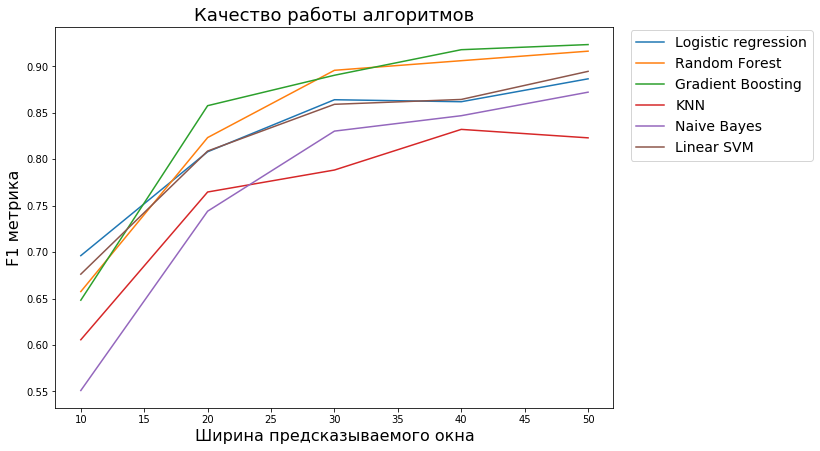

In [469]:

estimators_clf_qlt = {key:[] for key in ESTIMATORS_CLF.keys()}
for window_size, quality_clf in prediction_quality:
    for clf_type in quality_clf.keys():
        estimators_clf_qlt[clf_type].append(quality_clf[clf_type])

plots = []

plt.figure(figsize=(10,7))
plt.title("Качество работы алгоритмов", fontsize=18)
plt.xlabel("Ширина предсказываемого окна", fontsize=16)
plt.ylabel("F1 метрика", fontsize=16)
for e in estimators_clf_qlt.keys():
    p,  = plt.plot(future_windows, estimators_clf_qlt[e], label=e)
    plots.append(p)
    
plt.legend(handles=plots, loc='upper right', fontsize=14, bbox_to_anchor=(1.37, 1.01))
#качество регрессии с шириной окна 50
prediction_quality[-1][-1]

Качество обучения с шириной окна 50


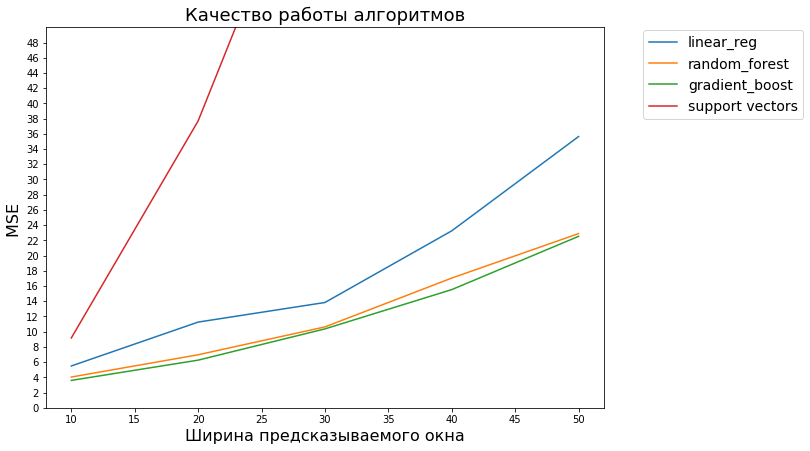

In [482]:
prediction_quality_reg

estimators_reg_qlt = {key:[] for key in ESTIMATORS_REG.keys()}
for window_size, quality_reg in prediction_quality_reg:
    for reg_type in quality_reg.keys():
        estimators_reg_qlt[reg_type].append(quality_reg[reg_type])

plots = []

plt.figure(figsize=(10,7))
plt.title("Качество работы алгоритмов", fontsize=18)
plt.xlabel("Ширина предсказываемого окна", fontsize=16)
plt.ylabel("MSE ", fontsize=16)
plt.yticks(np.arange(0, 50, step=2))
plt.ylim(0, 50)
for e in estimators_reg_qlt.keys():
    
        p,  = plt.plot(future_windows, estimators_reg_qlt[e], label=e)
        plots.append(p)
    
plt.legend(handles=plots, loc='upper right', fontsize=14, bbox_to_anchor=(1.37, 1.01))

print("Качество обучения с шириной окна 50")


Как видно из данного графика качество предсказания алгоритма тем точнее, чем меньше ширина окна, поэтому выбор ширины окна в данной задаче представляет собой компромисс между качеством работы классификатора и регрессора.

Как видно из экспериментов, чем выше ширина окна лучше модели предсказывают наступление поломки, связанно это  скорее всего с тем, что как правило количество циклов от начала аномального поведения прибора до поломки равно примерно 50 - 60 циклам, поэтому классы с шириной такоей шириной окна отличаются друг от друг наиболее сильно наилучшее качество предсказания достигается градиентным бустингом с шириной окна 50

Нейросетевой подход, основан на предположении, что поломка прибора может быть смоделирована распределением Вейбулла.

Плотность распределения задаётся по следующей формуле:
    $$f(x)= \frac{\beta}{\alpha} * (\frac{x}{\alpha})^{\beta-1} * e^{-(\frac{x}{\alpha})^{\beta}} $$
С помошью реккурентных нейросетей будем решать задачу максимизации  функции правдоподобия:
    $$f(y_{t+s}| \theta, x[:t]) -> max$$, где функция правдоподобия зависит от параметров нейросети и  предыдущих наблюдений


In [483]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [486]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset


#лосс функция
def weibull_loglik_discrete(y_true, ab_pred):
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]
    
    

    hazard0 = torch.pow((y_true ) / a_, b_)
    hazard1 = torch.pow((y_true + 1) / a_, b_)
    #print("Hazards", hazard0, hazard1)
    return -1 * torch.mean(torch.log(torch.exp(hazard1 - hazard0) - 1.0) - hazard1)


#функция активации нейронов
def activate(ab):
    a = torch.exp(ab[:, 0])
    b = torch.nn.Softplus()(ab[:, 1])

    return torch.stack((a, b), axis=1)

Создание датсетов для решаемой задачи, размер последовательности с которой работает RNN в данной задаче выбран равным 100. Данные преставляют собой тензор следующей формы: 
(количество_наблюдений, предыдущие наблюдения=100, исходные временные признаки - показания приборов = 16)

In [491]:

def create_rnn_data(engine, time, x, max_time, mask_value):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = []
    
    # number of features
    d = x.shape[1]
    start = 0
    # A full history of sensor readings to date for each x
    out_x = []

    engines_id = engine.unique()
    for i in engines_id:
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_engine_time = int(np.max(time[engine == i])) + 1


        this_x = []

        for j in range(start, max_engine_time):

            engine_x = x[engine == i]
            out_y.append(max_engine_time - j)

            xtemp = np.zeros((1, max_time, d))

            xtemp += mask_value
#            
            xtemp[:, max_time-min(j, max_time-1)-1:max_time, :] = engine_x.iloc[max(0, j-max_time+1):j+1, :]
            this_x.append(xtemp)
            
        this_x = np.concatenate(this_x)
        out_x.append(this_x)
    out_x = np.concatenate(out_x)
    out_y = np.asarray(out_y)
    return out_x, out_y

In [493]:
# # Configurable observation look-back period for each engine/day
max_time = 100
mask_value = 0

engines_train = train_set[id_col]
preds_ids = np.unique(engines_train)
cycles_train = train_set[cycle_col]
X_train = train_set[feature_cols]
#print(np.asarray(engines_train), np.asarray(cycles_train))

train_x, train_y = create_rnn_data(engine=engines_train, time=cycles_train, 
                              x=X_train, max_time=max_time, mask_value=mask_value)

print("Форма данных", train_x.shape)

Форма данных (13069, 100, 16)


Определим рекуррентные нейросетевые модели

In [505]:
BATCH_SIZE = 10
class RNN(nn.Module):
    def __init__(self, rnn_type, input_size=20, hidden_layer_size=200, output_size=2, batch_size=BATCH_SIZE):
        super(RNN, self).__init__()
        self.rnn_type = rnn_type
        self.hidden_layer_size = hidden_layer_size
        if (rnn_type == 'LSTM'):
            self.rnn = nn.LSTM(input_size, 
                                hidden_layer_size,
                               
                                batch_first=True,
                               )
            self.hidden_cell = (torch.zeros(1, batch_size, self.hidden_layer_size, requires_grad=False),
                            torch.zeros(1, batch_size, self.hidden_layer_size, requires_grad=False))
            
        elif (rnn_type == 'GRU'):
            self.rnn= nn.GRU(input_size, 
                             hidden_layer_size,
                             batch_first=True,
                            )
            
            self.hidden_cell = torch.zeros(1, batch_size, self.hidden_layer_size, requires_grad=False)

        self.linear1 = nn.Linear(hidden_layer_size, output_size)
        
        
    
    def forward(self, x):
        
        
        #self.hidden_cell.detach_()
        lstm_out, self.hidden_cell = self.rnn(x, self.hidden_cell)
        if (self.rnn_type == 'LSTM'):
            self.hidden_cell[0].detach_()
            self.hidden_cell[1].detach_()
        elif (self.rnn_type == 'GRU'):
            self.hidden_cell.detach_()
            

        lstm_out = lstm_out[:, -1, :]
        x = self.linear1(lstm_out)

        
        out = activate(x)
        return out

In [506]:
network = RNN('LSTM', 16, 100)
pytorch_total_params = sum(p.numel() for p in network.parameters())
print("Parametrs:", pytorch_total_params, network)

#network

Parametrs: 47402 RNN(
  (rnn): LSTM(16, 100, batch_first=True)
  (linear1): Linear(in_features=100, out_features=2, bias=True)
)


In [507]:
train_dataset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

criterion = weibull_loglik_discrete
optimizer = optim.Adam(network.parameters())

In [509]:
#Pytorch train process

FREQ = 1
total_loss = []
for epoch in range(1, 11, 1):
        losses = []
        for idx, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = network(X.float())
            loss = criterion(y, pred)
            #if idx % 10 == 0:
            #    print(loss.item())
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        if epoch % FREQ == 0:
            total_loss.append(sum(losses) / len(losses))
            print("Epoch : {} | avg_loss:{}|".format(epoch, sum(losses) / len(losses)))    

Epoch : 1 | avg_loss:6.08691999941471|
Epoch : 2 | avg_loss:5.531804397314285|
Epoch : 3 | avg_loss:5.470026364552847|
Epoch : 4 | avg_loss:5.404824492759763|
Epoch : 5 | avg_loss:5.343686084834942|
Epoch : 6 | avg_loss:5.316035625397885|
Epoch : 7 | avg_loss:5.308702702361629|
Epoch : 8 | avg_loss:5.305045061783257|
Epoch : 9 | avg_loss:5.296903747146747|
Epoch : 10 | avg_loss:5.329947429630694|


Text(0, 0.5, 'Loss')

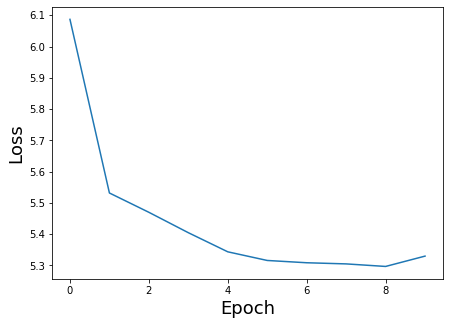

In [510]:
torch.save(network.state_dict(), 'LSTM.pth')
plt.figure(figsize=(7, 5))
plt.plot(range(len(total_loss)), total_loss)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)


In [513]:

engines_test = test_set[id_col]
cycles_test = test_set[cycle_col]
X_test = test_set[feature_cols]
test_x, test_y = create_rnn_data(engine=engines_test, time=cycles_test, 
                              x=X_test, max_time=max_time, mask_value=mask_value)

In [516]:

engines_ids = np.unique(engines_test)
engines_ids

array([11, 15, 17, 22, 25, 37, 41, 42, 48, 55, 57, 61, 69, 72, 75, 76])

In [519]:
TEST_BATCH_SIZE = 1
network = RNN('LSTM', 16,100)
network.load_state_dict(torch.load("LSTM.pth"))
network.eval()

network.hidden_cell = (torch.zeros(1, TEST_BATCH_SIZE, network.hidden_layer_size, requires_grad=False),
                        torch.zeros(1, TEST_BATCH_SIZE, network.hidden_layer_size, requires_grad=False))

Для каждого прибора и момента времени предскажем время поломки

In [520]:

total_params = []
for engine_id in engines_ids:
    engine_params = []
    cycles_test_engine = np.asarray(cycles_test[engines_test == engine_id])
    features_test_engine = np.asarray(test_x[engines_test == engine_id])
    y = test_y[engines_test == engine_id]
    for cycle in cycles_test_engine:
        seq = features_test_engine[cycle]
        torch_seq = torch.from_numpy(np.expand_dims(seq, axis=0)).float()
        pred = network(torch_seq)[0]
        engine_params.append((cycle, pred.detach().numpy()))
    total_params.append((engine_id, engine_params))

<IPython.core.display.Javascript object>


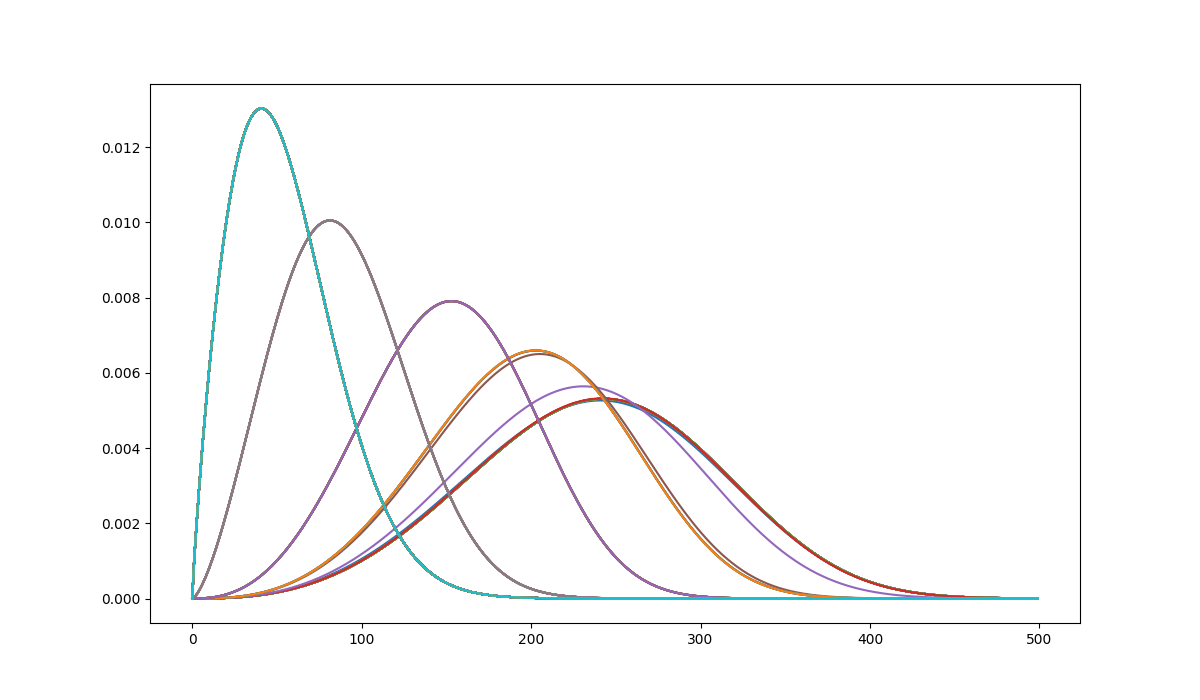

In [603]:
#формула для плотности распределния Вейбулла
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def plot_weibull_distribution(x_values, alpha, beta):
    pdf_values = []
    for x_value in x_values:
        #print(alpha, beta)
        pdf_values.append(weibull_pdf(alpha, beta, x_value))

    
    plt.plot(x_values, pdf_values)

plt.figure(figsize=(10, 7))
#
engine_id, engine_params = total_params[0]

for i in range(len(engine_params)):
    
    plot_weibull_distribution(range(500), engine_params[i][1][0], engine_params[i][1][1])

На данном графике видно, как изменяется плотность распределения:чем ближе прибор к поломке тем, распределение  имеет более вытянутую форму и мода близка к нулю

Создание анимации того как происходит изменение распределения наступления события в зависимости от бизости к поломке

<IPython.core.display.Javascript object>


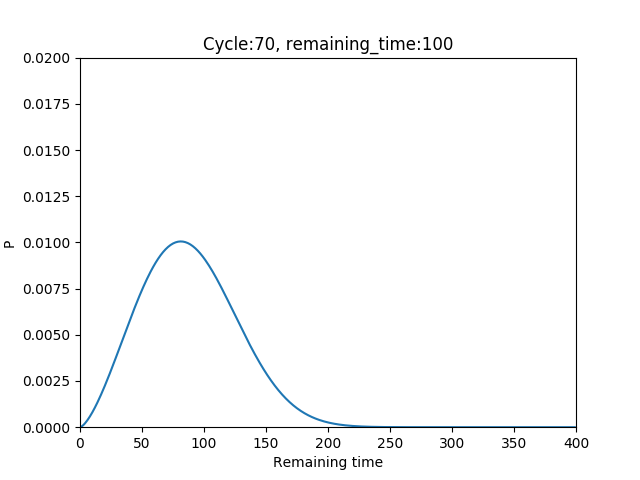

In [601]:
from matplotlib.animation import FuncAnimation

engine_id, engine_params = total_params[0]


x_values = range(len(engine_params))

fig, ax = plt.subplots()
ax.set_xlim(0, 400)
ax.set_ylim(0, 0.2)
LIMIT = 400

def animate(i):
    ax.clear()
    pdf_values = []
    y.append(i)
    alpha = engine_params[i][1][0]
    beta = engine_params[i][1][1]

    for t in range(LIMIT):
        
        pdf_values.append(weibull_pdf(alpha, beta, t))
    
    ax.set_title("Cycle:{}, remaining_time:{}".format(i, len(engine_params) - i))
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 0.02)
    ax.set_xlabel("Remaining time")
    ax.set_ylabel("P")
    line = ax.plot(range(LIMIT), pdf_values)
    return line
anim = animation.FuncAnimation(fig, animate,
                                      frames=x_values,
                                      repeat = True)

anim.save('a.gif',writer='imagemagick', fps=30)


По нахождению близкому нахождению моды к 0 можно, считать, что скоро произойдет поломка в качестве порога можно взять mode_position < 50

Решение данной задачи можно перенести на различные ситуации из реальной жизни, когда происходят какие-то события, не обязательно поломки;в качестве событий может выступить время, когда произойдет банкротство фирмы, отписка клиента и т.д, а в качестве исходных данных выступают последовательные измерения